# Практическая работа №4
# Деревья решений

## Импорт необходимых библиотек

In [1]:
import warnings

import graphviz

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, \
    plot_tree, export_graphviz
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score

from imblearn.under_sampling import RandomUnderSampler

from functions import draw_graphics, plot_histogram

warnings.filterwarnings('ignore')

## Задача классификации
### Загрузка данных для задачи классификации

In [2]:
dataframe_train_clas = pd.read_csv("../data/train_clas.csv")
dataframe_test_clas = pd.read_csv("../data/test_clas.csv")
dataframe_train_clas.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,213892,Male,48,1,35.0,1,1-2 Year,No,24922.0,26.0,86,0
1,269011,Male,58,1,28.0,0,1-2 Year,Yes,63541.0,26.0,57,0
2,31464,Male,44,1,28.0,1,1-2 Year,No,30027.0,26.0,286,0
3,86379,Female,22,1,8.0,0,< 1 Year,Yes,35039.0,152.0,180,0
4,456843,Male,24,1,6.0,1,< 1 Year,No,24149.0,152.0,17,0
5,195890,Female,49,1,28.0,0,1-2 Year,Yes,2630.0,157.0,156,0
6,111681,Male,28,1,6.0,1,< 1 Year,No,31154.0,152.0,150,0
7,427068,Male,22,1,12.0,1,< 1 Year,No,27956.0,152.0,174,0
8,337519,Female,25,1,14.0,1,< 1 Year,No,32658.0,152.0,32,0
9,12666,Male,47,1,0.0,0,1-2 Year,Yes,2630.0,26.0,79,0


### Предварительная обработка исходных данных
Выведем информацию о таблицах.

In [3]:
dataframe_train_clas.info()
dataframe_test_clas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    229292 non-null  int64  
 1   Gender                229292 non-null  object 
 2   Age                   229292 non-null  int64  
 3   Driving_License       229292 non-null  int64  
 4   Region_Code           229292 non-null  float64
 5   Previously_Insured    229292 non-null  int64  
 6   Vehicle_Age           229292 non-null  object 
 7   Vehicle_Damage        229292 non-null  object 
 8   Annual_Premium        229292 non-null  float64
 9   Policy_Sales_Channel  229292 non-null  float64
 10  Vintage               229292 non-null  int64  
 11  Response              229292 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 21.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152862 entries, 0 to 152861
Data columns (total 

In [4]:
dataframe_train_clas.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Из вывода видно, что в столбцах нет пустых значений
Так как признак id не играет важной роли в предсказании, то можем удалить его из датафреймов.

In [5]:
dataframe_train_clas.drop("id", axis=1, inplace=True)
test_ids_clas = dataframe_test_clas["id"]
dataframe_test_clas.drop("id", axis=1, inplace=True)

Разделим наши признаки на категориальные и числовые.

In [6]:
dataframe_categorical_clas = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
dataframe_numerical_clas = ["Age", "Driving_License", "Previously_Insured",
                            "Region_Code", "Annual_Premium",
                            "Policy_Sales_Channel",
                            "Vintage"]
dataframe_all_clas = dataframe_numerical_clas + dataframe_categorical_clas
result_column_clas = "Response"

Для классификации выберем 10000 элементов из датафрейма, используя метод сэмплирования из библиотеки Pandas.

In [7]:
number_of_elements = 20000  # Количество элементов
dataframe_train_clas = dataframe_train_clas.sample(n=number_of_elements,
                                                   replace=False)  # replace: флаг, указывающий, следует ли использовать повторения при выборке.
dataframe_train_clas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 78897 to 16184
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                20000 non-null  object 
 1   Age                   20000 non-null  int64  
 2   Driving_License       20000 non-null  int64  
 3   Region_Code           20000 non-null  float64
 4   Previously_Insured    20000 non-null  int64  
 5   Vehicle_Age           20000 non-null  object 
 6   Vehicle_Damage        20000 non-null  object 
 7   Annual_Premium        20000 non-null  float64
 8   Policy_Sales_Channel  20000 non-null  float64
 9   Vintage               20000 non-null  int64  
 10  Response              20000 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.8+ MB


Произведём кодирование категориальных признаков

In [8]:
label_encoder = LabelEncoder()
for column in dataframe_categorical_clas:
    dataframe_train_clas[column] = label_encoder.fit_transform(
        dataframe_train_clas[column])
    dataframe_test_clas[column] = label_encoder.fit_transform(
        dataframe_test_clas[column])

    dataframe_train_clas[column] = dataframe_train_clas[column].astype(
        "category")
    dataframe_test_clas[column] = dataframe_test_clas[column].astype("category")
    print(dataframe_train_clas[column].unique())

[0, 1]
Categories (2, int64): [0, 1]
[0, 1, 2]
Categories (3, int64): [0, 1, 2]
[1, 0]
Categories (2, int64): [0, 1]


Произведём нормирование числовых признаков

In [9]:
min_max_scaler = MinMaxScaler()
dataframe_train_clas[dataframe_numerical_clas] = min_max_scaler.fit_transform(
    dataframe_train_clas[dataframe_numerical_clas])
dataframe_test_clas[dataframe_numerical_clas] = min_max_scaler.fit_transform(
    dataframe_test_clas[dataframe_numerical_clas])
dataframe_train_clas.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.285978,0.998200,0.506705,0.491700,0.084227,0.684102,0.499943,0.162800
std,0.234683,0.042389,0.253422,0.499944,0.050495,0.335907,0.290742,0.369192
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,1.000000,0.288462,0.000000,0.065832,0.154321,0.249135,0.000000
50%,0.246154,1.000000,0.538462,0.000000,0.087186,0.901235,0.498270,0.000000
75%,0.446154,1.000000,0.673077,1.000000,0.110299,0.932099,0.754325,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Сэмплирование данных

In [10]:
x_clas = dataframe_train_clas[dataframe_all_clas]
y_clas = dataframe_train_clas[result_column_clas]

x_clas, y_clas = RandomUnderSampler().fit_resample(x_clas, y_clas)

In [11]:
x_train_clas, x_test_clas, y_train_clas, y_test_clas = train_test_split(x_clas,
                                                                        y_clas,
                                                                        test_size=0.3,
                                                                        random_state=7)

### Построение дерева решений

In [12]:
def draw_decision_tree(x_train: pd.DataFrame, y_train: pd.DataFrame,
                       dataframe: pd.DataFrame,
                       tree: (DecisionTreeClassifier, DecisionTreeRegressor),
                       path_to_file: str):
    """
    Строит и визуализирует дерево решений для задачи классификации или регрессии на основе обучающих данных.
    :param dataframe: Датафрейм
    :param x_train: Признаки
    :param y_train: Целевой признак
    :param tree: Дерево решений
    :param path_to_file: Путь к файлу, где будет сохранено дерево
    :return: None
    """

    dot_data = export_graphviz(tree, out_file=None,
                               feature_names=dataframe.columns, filled=True,
                               rounded=True, special_characters=True)
    graph = graphviz.Source(dot_data)
    graph.render(path_to_file)

    return graph


In [13]:
def train_decision_tree(tree, param_grid: dict, scoring, x_train,
                        y_train) -> GridSearchCV:
    print("Исследование зависимости качества прогнозирования от параметров...")

    new_tree = GridSearchCV(tree, param_grid, scoring=scoring, n_jobs=-1,
                            cv=5).fit(x_train, y_train)

    print(new_tree.best_estimator_)
    # выводим лучшие значения параметров и соответствующее значение score
    print("Best accuracy:", round(new_tree.best_score_, 3))

    return new_tree

In [14]:
# задаем диапазон значений для параметров criterion, max_features и max_depth
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 5, 8, 11, 14, 17, 20],
    "max_leaf_nodes": [5, 10, 15, 20, 25],
    "min_samples_leaf": [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "min_samples_split": [10, 12, 14, 16, 18, 20]
    # минимальное количество выборок, необходимое для разбиения внутреннего узла.
}

result_clas_tree = train_decision_tree(DecisionTreeClassifier(random_state=42),
                                       param_grid, "roc_auc", x_train_clas,
                                       y_train_clas)
print("ROC-AUC: " + str(
    round(result_clas_tree.score(x_test_clas, y_test_clas), 3)))
round(
    cross_val_score(result_clas_tree, dataframe_train_clas[dataframe_all_clas],
                    dataframe_train_clas[result_column_clas], n_jobs=-1)[0], 3)

Исследование зависимости качества прогнозирования от параметров...
DecisionTreeClassifier(criterion='entropy', max_depth=14, max_leaf_nodes=25,
                       min_samples_leaf=6, min_samples_split=20,
                       random_state=42)
Best accuracy: 0.885
ROC-AUC: 0.884


0.882

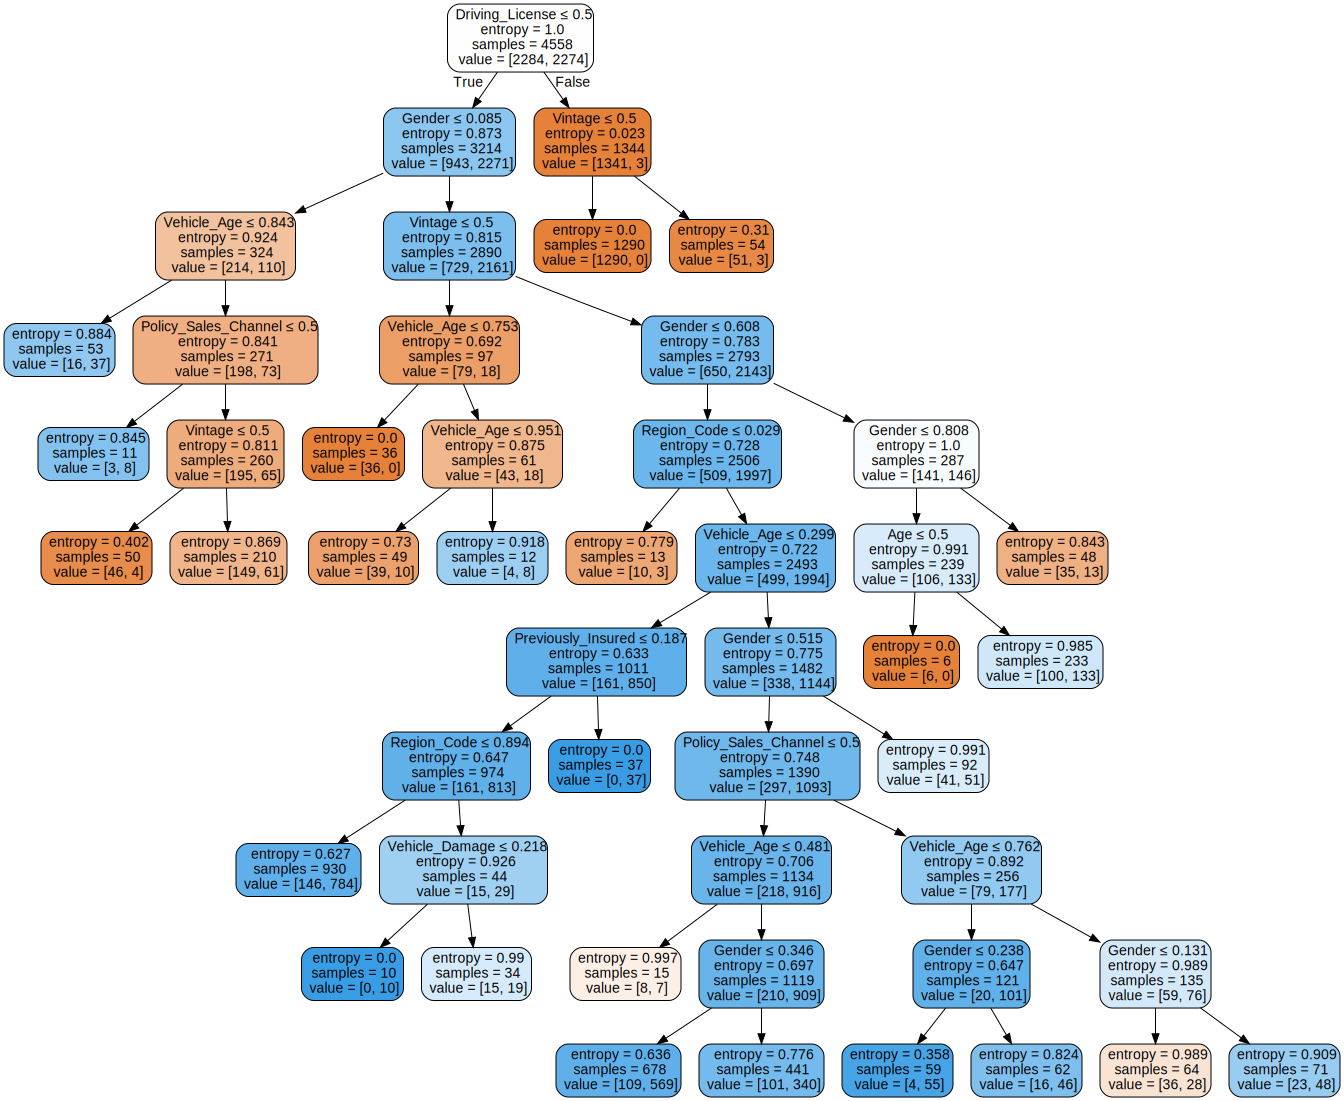

In [15]:
draw_decision_tree(x_train_clas, y_train_clas,
                   dataframe_train_clas.drop(result_column_clas, axis=1),
                   result_clas_tree.best_estimator_,
                   "../pdf/tree_clas")

### Графики зависимости значений метрик от значений параметров модели

In [16]:
def create_and_train_tree_clas(parameters_values: dict) -> None:
    """
    Функция, отвечающая за перебор различных параметров деревьев решений и вычисления
    значений оценок на тестовой и обучающей выборках.
    :param parameters_values: Словарь с перебираемыми параметрами
    :return: None
    """
    # Перебираем ключи и значения словаря parameters_values
    for parameter_name, parameter_value in parameters_values.items():
        # Получаем диапазон, тренировочные и тестовые значения из вложенного словаря
        parameter_range = parameter_value['range']
        train_scores = parameter_value['train_scores']
        test_scores = parameter_value['test_scores']

        for value in parameter_range:

            if parameter_name is "max_depth":
                default_tree = DecisionTreeClassifier(max_depth=value, random_state=3)
            elif parameter_name is "max_leaf_nodes":
                default_tree = DecisionTreeClassifier(max_leaf_nodes=value, random_state=3)
            elif parameter_name is "min_samples_leaf":
                default_tree = DecisionTreeClassifier(min_samples_leaf=value, random_state=3)
            elif parameter_name is "min_samples_split":
                default_tree = DecisionTreeClassifier(min_samples_split=value, random_state=3)

            # Обучаем классификатор на обучающей выборке
            default_tree.fit(x_train_clas, y_train_clas)

            # Предсказываем вероятности для обучающей выборки
            y_pred = default_tree.predict_proba(x_train_clas)[:, 1]

            # Вычисляем значение roc_auc на обучающей выборке
            train_score = roc_auc_score(y_train_clas, y_pred)
            train_scores.append(train_score)

            # Предсказываем вероятности для тестовой выборки
            y_pred = default_tree.predict_proba(x_test_clas)[:, 1]

            # Вычисляем значение roc_auc на тестовой выборке
            test_score = roc_auc_score(y_test_clas, y_pred)
            test_scores.append(test_score)

In [17]:
parameters_values_clas = {
    'max_depth': {
        'range': range(1, 21),
        'train_scores': [],
        'test_scores': [],
    },
    'max_leaf_nodes': {
        'range': range(2, 26),
        'train_scores': [],
        'test_scores': [],
    },
    "min_samples_leaf": {
        'range': range(1, 21),
        'train_scores': [],
        'test_scores': [],
    },
    "min_samples_split": {
        'range': range(2, 15),
        'train_scores': [],
        'test_scores': [],
    },
}

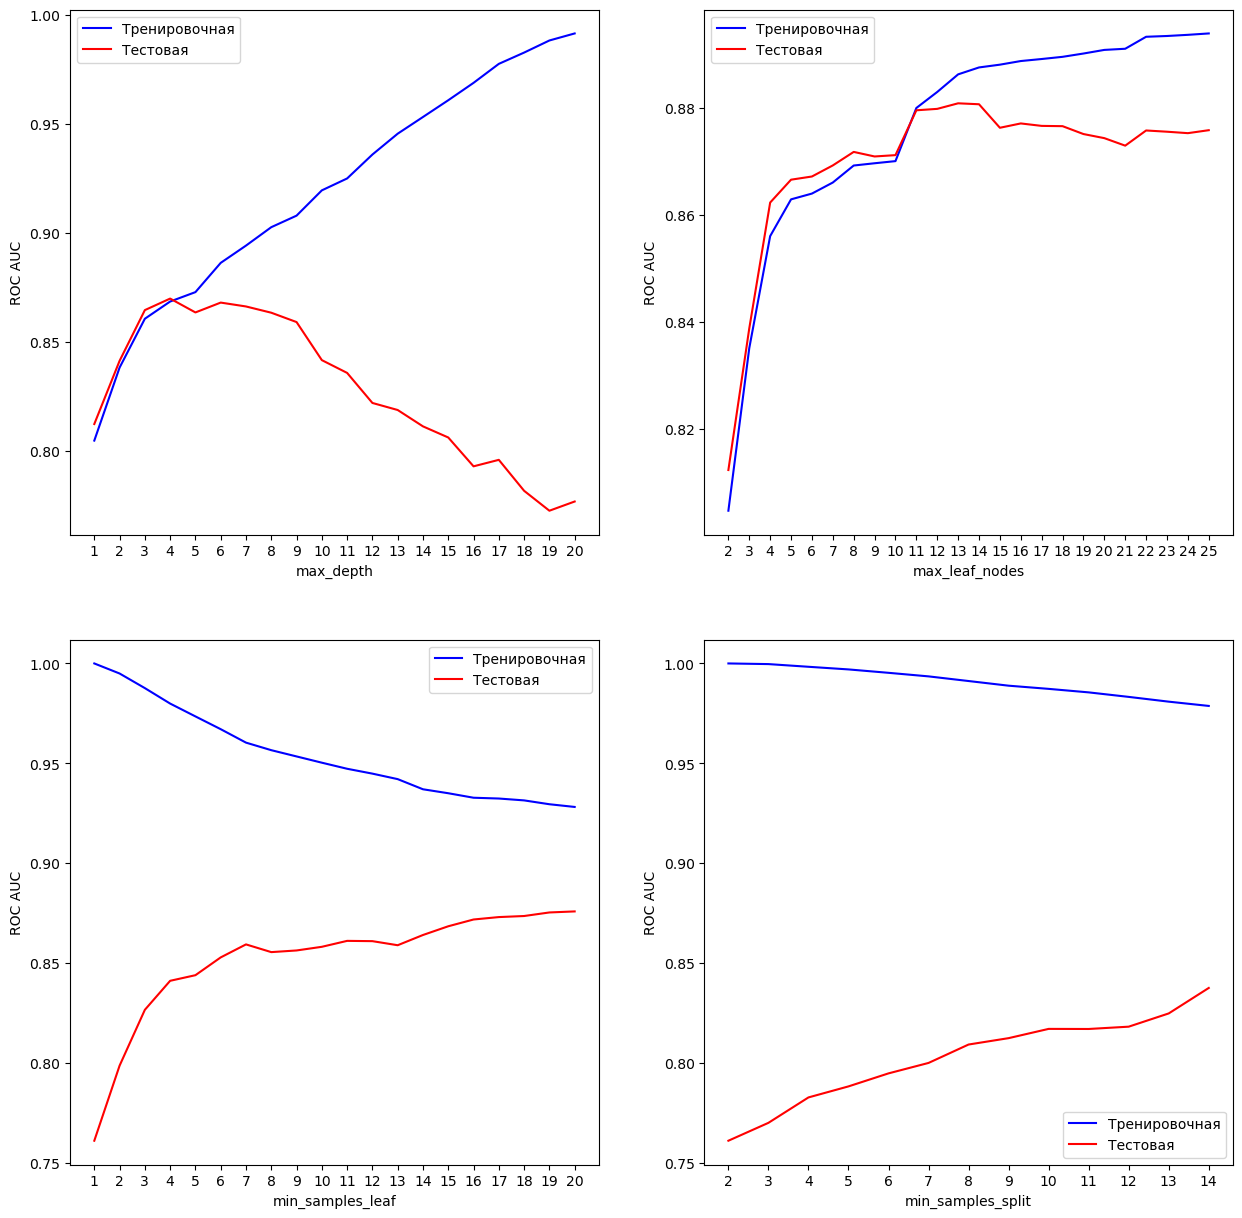

In [18]:
create_and_train_tree_clas(parameters_values_clas)
draw_graphics(parameters_values_clas, "ROC AUC")

Можно сделать вывод, что оптимальными для дерева решений будут следующие параметры. max_depth: от 5 до 8, max_leaf_nodes: от 16 до 20, min_samples_leaf: от 15 до 18, min_samples_split: от 10 до 13.

### Сравнение результатов

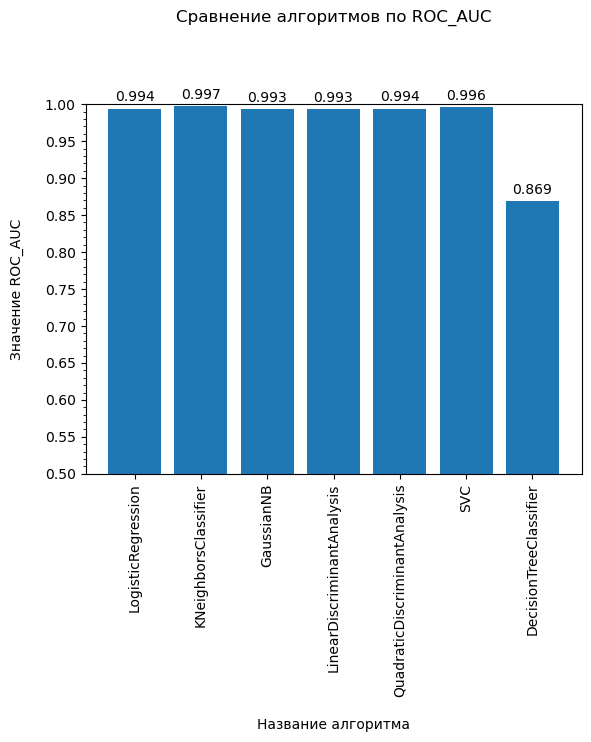

In [19]:
data = {
    "LogisticRegression": 0.994,
    "KNeighborsClassifier": 0.997,
    "GaussianNB": 0.993,
    "LinearDiscriminantAnalysis": 0.993,
    "QuadraticDiscriminantAnalysis": 0.994,
    "SVC": 0.996,
    "DecisionTreeClassifier": 0.869,
}
plot_histogram(data, "ROC_AUC")

In [20]:
result = max(data, key=data.get)
print(f"Лучший алгоритм классификации: {result}")

Лучший алгоритм классификации: KNeighborsClassifier


Дерево решений справилось хуже. Скорее всего это связано с тем, что разделяющая граница, построенная деревом решений, имеет свои ограничения, поэтому оно по качеству классификации уступает другому методу.

## Задача регрессии
### Загрузка данных для задачи классификации

In [21]:
dataframe_train_reg = pd.read_csv("../data/train_reg.csv")
dataframe_test_reg = pd.read_csv("../data/test_reg.csv")
dataframe_train_reg.head(10)

,id,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
0,896,2,0,46.0,3,5,0,0,0,0,...,2,3,0,7,3,13,2,7,18,2350000.0
1,399,2,0,44.6,5,5,0,0,0,0,...,3,5,0,7,3,11,1,4,11,1799000.0
2,1515,2,0,53.0,1,9,0,1,0,0,...,4,11,0,5,3,17,3,7,15,2800000.0
3,1216,2,0,64.0,4,5,0,0,0,1,...,31,5,1,55,2,10,28,32,17,3970000.0
4,677,1,0,33.3,1,10,0,0,1,0,...,1,3,0,2,3,9,0,3,6,1880000.0
5,1210,2,0,46.0,3,4,0,0,0,0,...,38,6,2,15,0,27,9,11,25,2400000.0
6,1485,1,0,45.0,8,9,0,1,0,0,...,8,9,0,8,1,33,4,4,15,2870000.0
7,1557,2,0,54.5,3,14,0,1,0,0,...,11,4,1,12,4,15,2,14,14,2700000.0
8,1482,4,0,86.0,1,10,0,1,0,0,...,16,11,0,9,2,42,12,10,30,3200000.0
9,295,2,0,42.0,2,5,0,0,0,0,...,22,5,0,10,1,13,2,13,17,2560000.0


Выведем информацию о таблицах.

In [22]:
dataframe_train_reg.info()
dataframe_test_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 48 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         808 non-null    int64  
 1   Количество.комнат          808 non-null    int64  
 2   Студия                     808 non-null    int64  
 3   Общая.площадь              808 non-null    float64
 4   Этаж                       808 non-null    int64  
 5   Этажей.в.доме              808 non-null    int64  
 6   Парковка                   808 non-null    int64  
 7   Без.ремонта                808 non-null    int64  
 8   Дизайнерский               808 non-null    int64  
 9   Евроремонт                 808 non-null    int64  
 10  Косметический              808 non-null    int64  
 11  Балкон                     808 non-null    int64  
 12  Лоджия                     808 non-null    int64  
 13  Совмещенный.санузел        808 non-null    int64  

In [23]:
dataframe_train_reg.isnull().sum()

id                           0
Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000 

Из вывода видно, что в столбцах нет пустых значений

Так как признак id не играет важной роли в предсказании, то можем удалить его из датафреймов.

In [24]:
dataframe_train_reg.drop("id", axis=1, inplace=True)
test_ids_reg = dataframe_test_reg["id"]
dataframe_test_reg.drop("id", axis=1, inplace=True)

Для задачи регрессии уже проведено кодирование категориальных признаков. Чтобы избежать «ловушки фиктивной переменной», необходимо сделать следующее: если у нас n вариантов категориального признака, то надо оставить n-1 фиктивных колонок после одноразового кодирования. Оставляя n-1 фиктивных колонок, мы убираем линейную зависимость между фиктивными колонками и делаем нашу модель более стабильной и точной.

In [25]:
dataframe_train_reg.drop("Евроремонт", axis=1, inplace=True)
dataframe_train_reg.drop("Совмещенный.санузел", axis=1, inplace=True)
dataframe_train_reg.drop("Деревянные.перекрытия", axis=1, inplace=True)
dataframe_train_reg.drop("Деревянные.стены", axis=1, inplace=True)

In [26]:
result_column_reg = "Цена"

# Получаем серию с количеством уникальных значений в каждом столбце
nunique = dataframe_train_reg.nunique()

# Фильтруем серию по условию (в данном случае выбираем столбцы с более чем 5 уникальными значениями)
first_nunique = nunique[nunique > 5]

second_nunique = nunique[nunique <= 5]

# Получаем индекс отфильтрованной серии
first_index = first_nunique.index
second_index = second_nunique.index

# Преобразуем индекс в список
dataframe_numerical_reg = first_index.tolist()
dataframe_numerical_reg.remove(result_column_reg)

# Преобразуем индекс в список
dataframe_categorical_reg = second_index.tolist()

dataframe_all_reg = dataframe_numerical_reg + dataframe_categorical_reg

Произведём кодирование категориальных признаков

In [27]:
min_max_scaler = MinMaxScaler()
dataframe_train_reg[dataframe_numerical_reg] = min_max_scaler.fit_transform(
    dataframe_train_reg[dataframe_numerical_reg])
dataframe_test_reg[dataframe_numerical_reg] = min_max_scaler.fit_transform(
    dataframe_test_reg[dataframe_numerical_reg])
dataframe_train_reg.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Косметический,Балкон,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,0.370738,0.169339,0.288985,0.142327,0.101485,0.024752,0.772277,0.632426,...,0.120611,0.333893,0.143564,0.116244,0.312655,0.315800,0.079803,0.168874,0.336757,2.699083e+06
std,0.996109,0.198046,0.180250,0.163514,0.198105,0.349601,0.302157,0.155466,0.419622,0.635417,...,0.179036,0.232571,0.378064,0.134081,0.204503,0.179949,0.114529,0.171839,0.201714,1.096460e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,0.251364,0.043478,0.125000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.023256,0.142857,0.000000,0.044776,0.125000,0.190476,0.019231,0.050000,0.175000,1.950000e+06
50%,2.000000,0.000000,0.345455,0.130435,0.291667,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.046512,0.285714,0.000000,0.089552,0.250000,0.309524,0.057692,0.125000,0.300000,2.550000e+06
75%,3.000000,0.000000,0.482500,0.217391,0.333333,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.139535,0.500000,0.000000,0.134328,0.500000,0.428571,0.096154,0.250000,0.475000,3.310000e+06
max,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.800000e+06


In [28]:
x_reg = dataframe_train_reg[dataframe_all_reg]
y_reg = dataframe_train_reg[result_column_reg]
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg,
                                                                    y_reg,
                                                                    test_size=0.3,
                                                                    random_state=7)

### Построение дерева решений

In [29]:
param_grid = {
    "criterion": ['friedman_mse', 'absolute_error', 'poisson', 'squared_error'],
    "max_depth": [2, 5, 8, 11, 14, 17, 20],
    "max_leaf_nodes": [5, 10, 15, 20, 25],
    "min_samples_leaf": [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "min_samples_split": [10, 12, 14, 16, 18, 20]
    # минимальное количество выборок, необходимое для разбиения внутреннего узла.
}

result_reg_tree = train_decision_tree(DecisionTreeRegressor(random_state=42),
                                       param_grid, "r2", x_train_reg,
                                       y_train_reg)
print("R^2: " + str(
    round(result_reg_tree.score(x_test_reg, y_test_reg), 3)))
round(
    cross_val_score(result_reg_tree, dataframe_train_reg[dataframe_all_reg],
                    dataframe_train_reg[result_column_reg], n_jobs=-1)[0], 3)

Исследование зависимости качества прогнозирования от параметров...
DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_leaf_nodes=25, min_samples_leaf=11,
                      min_samples_split=10, random_state=42)
Best accuracy: 0.885
R^2: 0.852


0.876

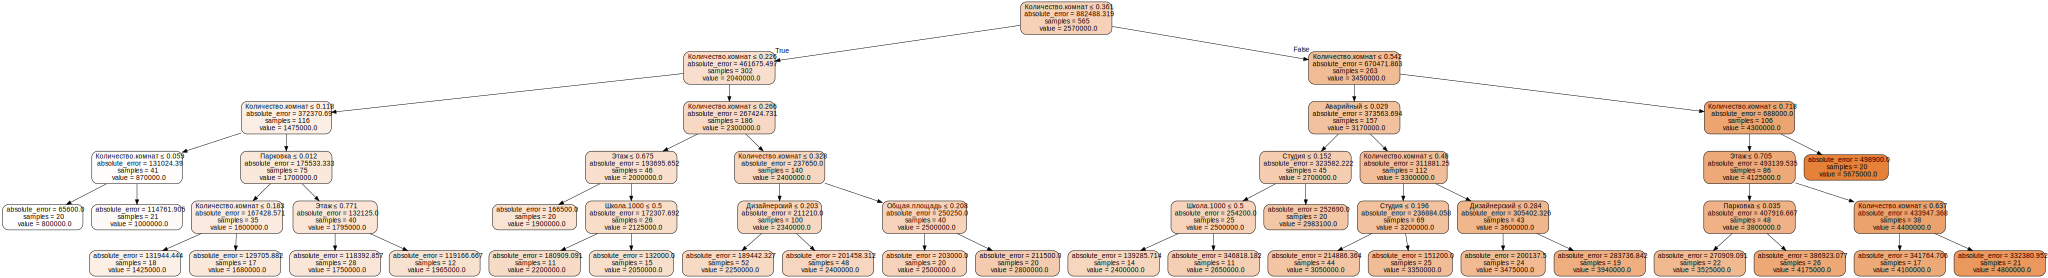

In [30]:
draw_decision_tree(x_train_reg, y_train_reg,
                   dataframe_train_reg.drop(result_column_reg, axis=1),
                   result_reg_tree.best_estimator_,
                   "../pdf/tree_reg")

### Графики зависимости значений метрик от значений параметров модели

In [31]:
def create_and_train_tree_reg(parameters_values: dict) -> None:
    """
    Функция, отвечающая за перебор различных параметров деревьев решений и вычисления
    значений оценок на тестовой и обучающей выборках.
    :param parameters_values: Словарь с перебираемыми параметрами
    :return: None
    """
    # Перебираем ключи и значения словаря parameters_values
    for parameter_name, parameter_value in parameters_values.items():
        # Получаем диапазон, тренировочные и тестовые значения из вложенного словаря
        parameter_range = parameter_value['range']
        train_scores = parameter_value['train_scores']
        test_scores = parameter_value['test_scores']

        for value in parameter_range:

            if parameter_name is "max_depth":
                default_tree = DecisionTreeRegressor(max_depth=value, random_state=3)
            elif parameter_name is "max_leaf_nodes":
                default_tree = DecisionTreeRegressor(max_leaf_nodes=value, random_state=3)
            elif parameter_name is "min_samples_leaf":
                default_tree = DecisionTreeRegressor(min_samples_leaf=value, random_state=3)
            elif parameter_name is "min_samples_split":
                default_tree = DecisionTreeRegressor(min_samples_split=value, random_state=3)

            # Обучаем классификатор на обучающей выборке
            default_tree.fit(x_train_reg, y_train_reg)

            # Предсказываем значения для обучающей выборки
            y_pred = default_tree.predict(x_train_reg)

            # Вычисляем значение r^2 на обучающей выборке
            train_score = r2_score(y_train_reg, y_pred)
            train_scores.append(train_score)

            # Предсказываем значения для тестовой выборки
            y_pred = default_tree.predict(x_test_reg)

            # Вычисляем значение r^2 на тестовой выборке
            test_score = r2_score(y_test_reg, y_pred)
            test_scores.append(test_score)

In [32]:
parameters_values_reg = {
    'max_depth': {
        'range': range(1, 21),
        'train_scores': [],
        'test_scores': [],
    },
    'max_leaf_nodes': {
        'range': range(2, 26),
        'train_scores': [],
        'test_scores': [],
    },
    "min_samples_leaf": {
        'range': range(1, 21),
        'train_scores': [],
        'test_scores': [],
    },
    "min_samples_split": {
        'range': range(2, 15),
        'train_scores': [],
        'test_scores': [],
    },
}

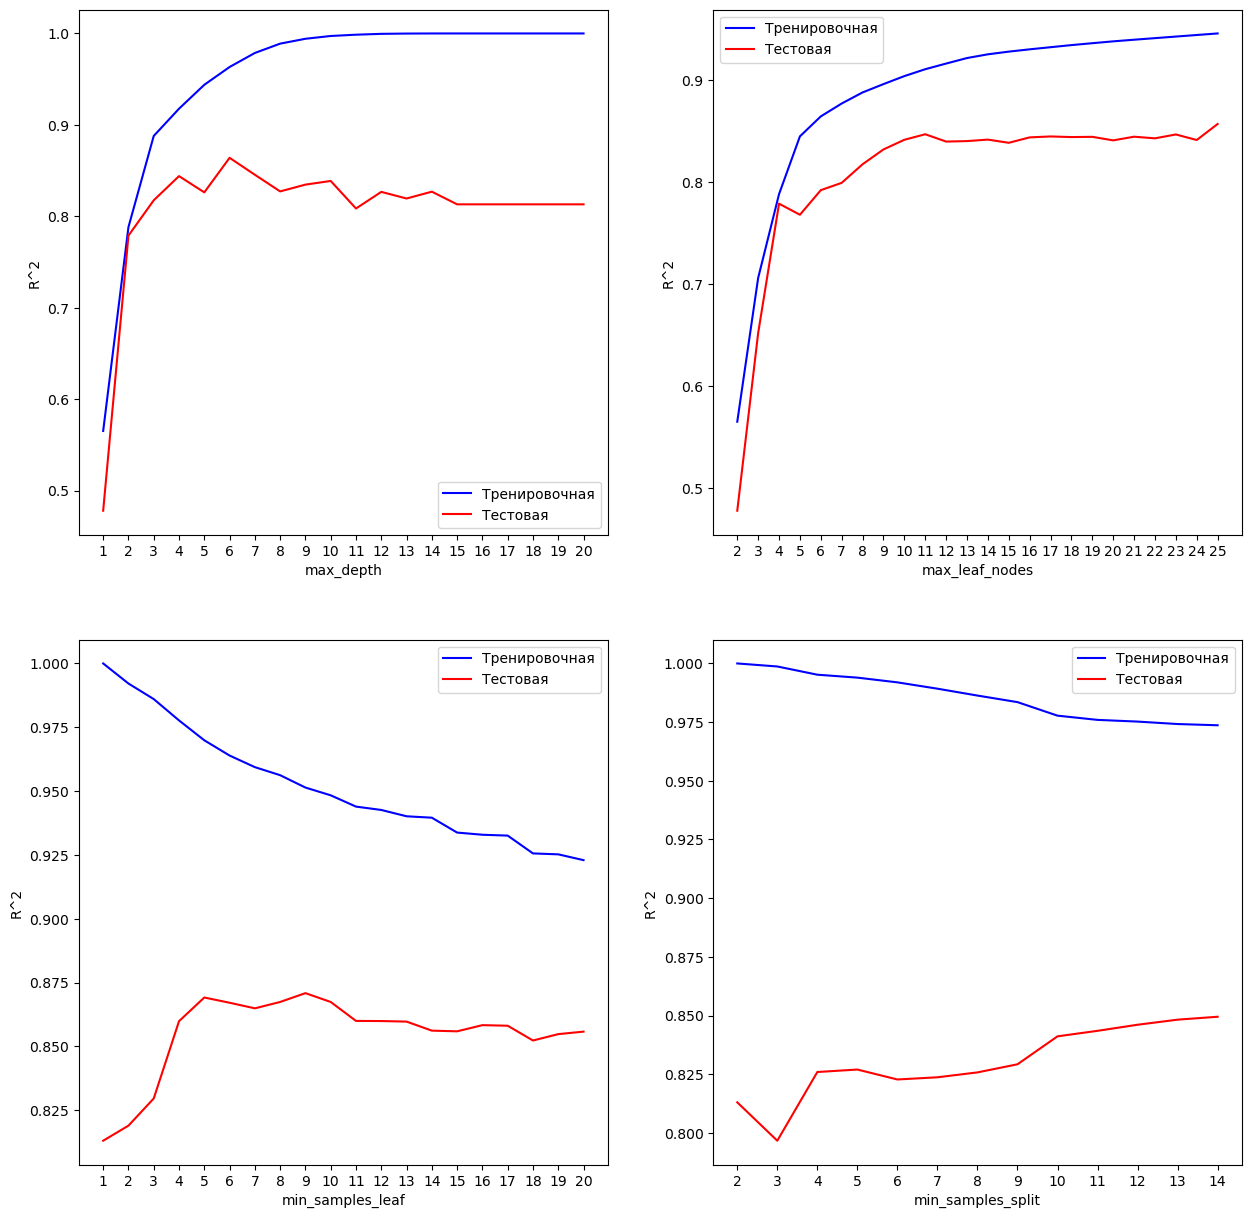

In [33]:
create_and_train_tree_reg(parameters_values_reg)
draw_graphics(parameters_values_reg, "R^2")

Можно сделать вывод, что оптимальными для дерева решений будут следующие параметры. max_depth: от 5 до 8, max_leaf_nodes: от 18 до 25, min_samples_leaf: от 11 до 15, min_samples_split: от 10 до 13.

### Сравнение результатов

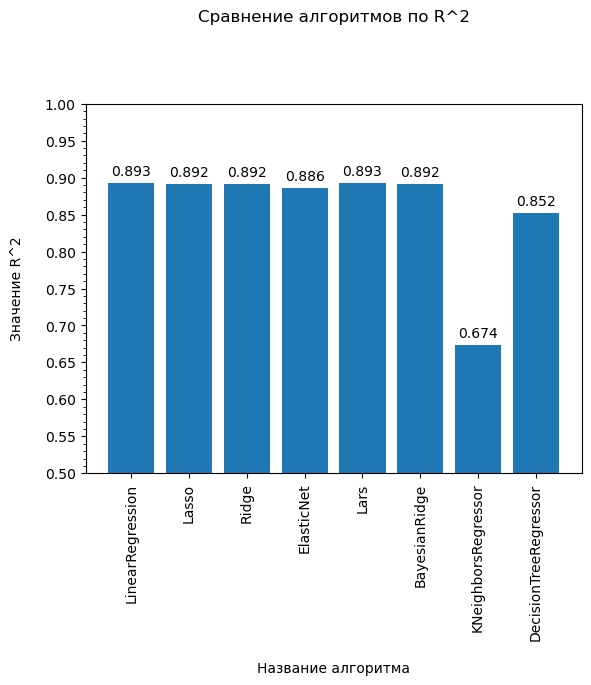

In [34]:
data = {
    "LinearRegression": 0.893,
    "Lasso": 0.892,
    "Ridge": 0.892,
    "ElasticNet": 0.886,
    "Lars": 0.893,
    "BayesianRidge": 0.892,
    "KNeighborsRegressor": 0.674,
    "DecisionTreeRegressor": 0.852,
}
plot_histogram(data, "R^2")

In [35]:
result = max(data, key=data.get)
print(f"Лучший алгоритм классификации: {result}")

Лучший алгоритм классификации: LinearRegression
